In [1]:
import rasterio as rio
import rioxarray as rxr
import numpy as np
import earthpy.plot as ep
import xarray as xr
import mapclassify

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

from shapely.geometry import shape, box
import geopandas as gpd

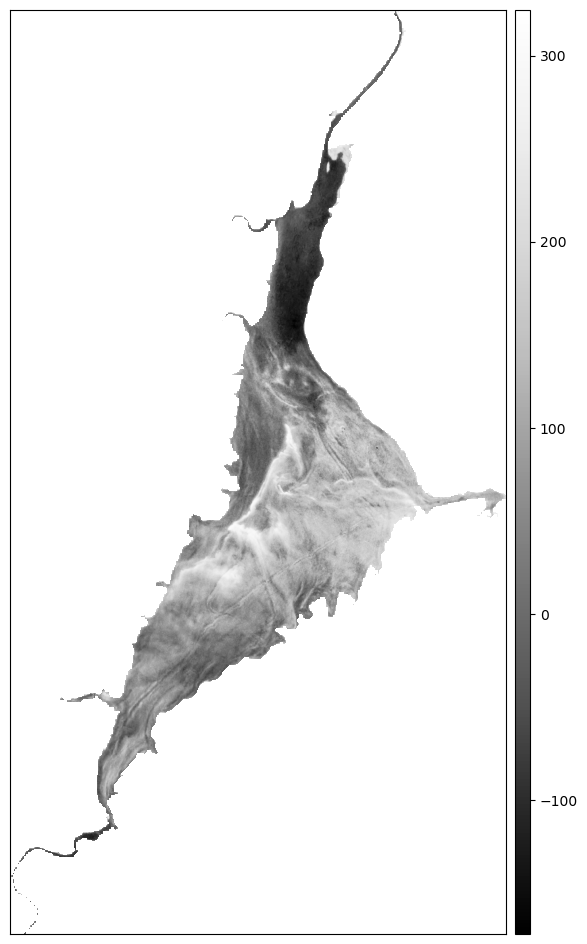

<Axes: >

In [2]:
ds = rxr.open_rasterio("output/ndvi_algo_20170222.tif", masked = True)

ep.plot_bands(ds)

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

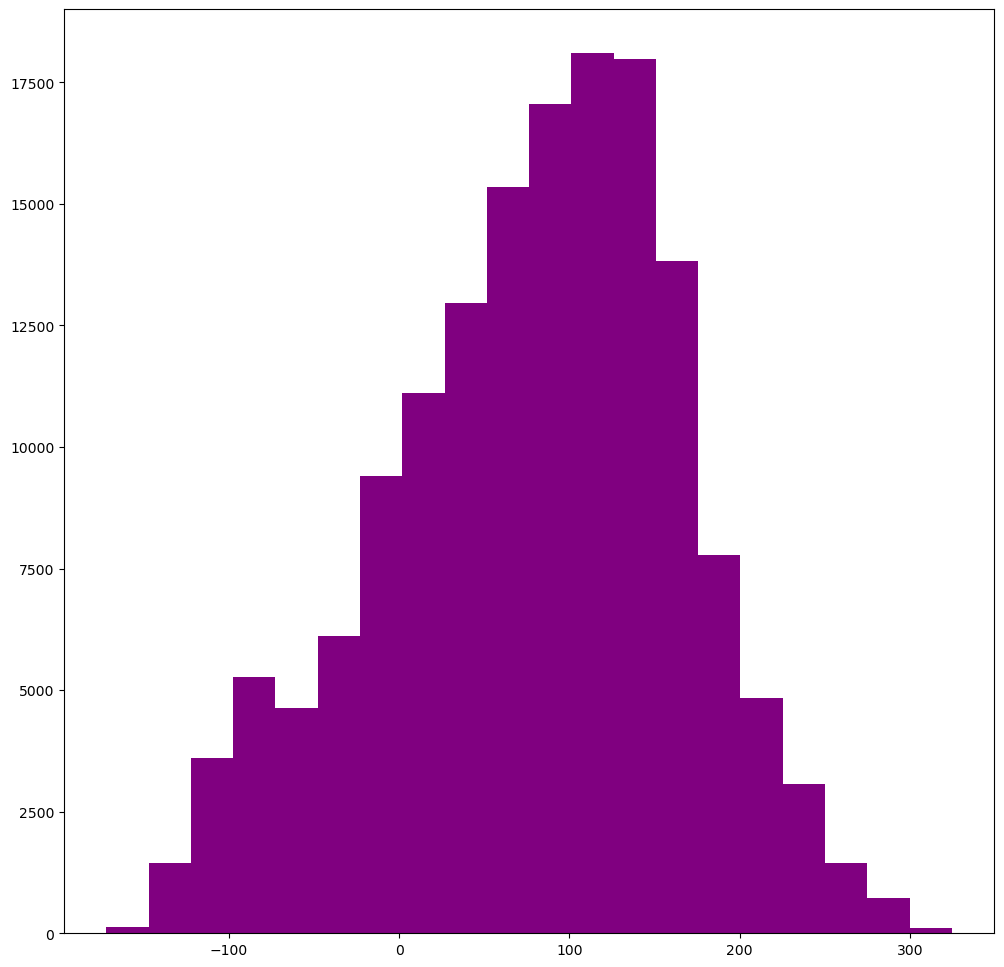

In [3]:
ep.hist(ds.data)

In [4]:
# Shows ideal values for binning
# options include EqualInterval or Quantiles or FisherJenks
# Latter takes quite a while
mapclassify.FisherJenks(ds.data[ds.data >= 0], k = 7)

FisherJenks

    Interval       Count
------------------------
[  0.00,  38.94] | 18145
( 38.94,  74.62] | 20916
( 74.62, 108.13] | 23206
(108.13, 140.87] | 24082
(140.87, 176.86] | 21334
(176.86, 222.40] | 11672
(222.40, 324.69] |  5797

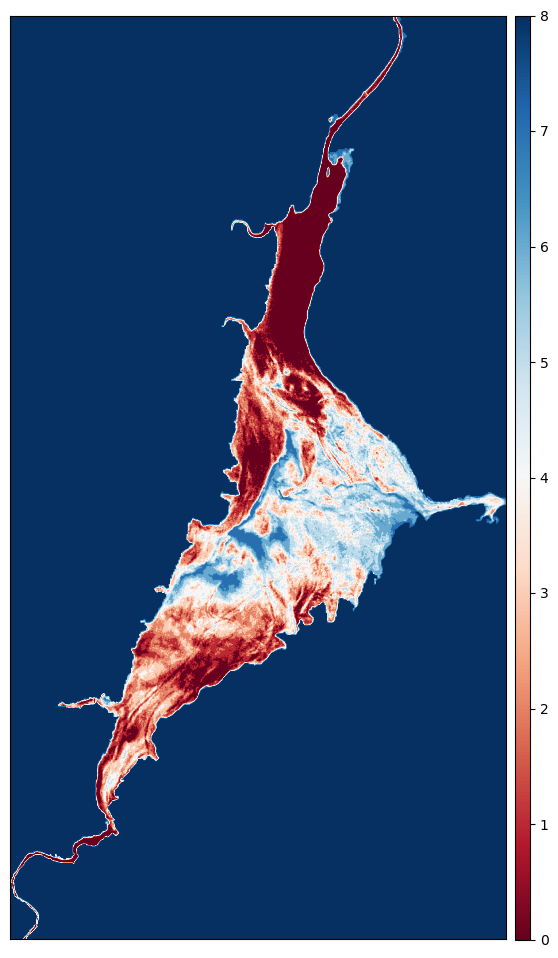

<Axes: >

In [5]:
# polygonize 
bins = [0, 39, 75, 108, 140, 176, 222, 325]

classified_chloro = xr.apply_ufunc(np.digitize, ds, bins)

ep.plot_bands(classified_chloro, cmap = "RdBu")

In [6]:
classified_chloro

<xarray.DataArray (band: 1, y: 1369, x: 735)>
array([[[8, 8, 8, ..., 8, 8, 8],
        [8, 8, 8, ..., 8, 8, 8],
        [8, 8, 8, ..., 8, 8, 8],
        ...,
        [8, 8, 8, ..., 8, 8, 8],
        [8, 8, 8, ..., 8, 8, 8],
        [8, 8, 8, ..., 8, 8, 8]]], dtype=int64)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.562e+05 3.562e+05 ... 3.636e+05 3.636e+05
  * y            (y) float64 6.535e+06 6.535e+06 ... 6.522e+06 6.522e+06
    spatial_ref  int32 0

In [7]:
classified_chloro = classified_chloro.where(~np.isnan(ds), 255)

classified_chloro = classified_chloro.astype(np.uint8) # recall uint8 is 0-255, int8 is -127 to 128
classified_chloro.rio.write_nodata(255, inplace = True) # set nodata value

<xarray.DataArray (band: 1, y: 1369, x: 735)>
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.562e+05 3.562e+05 ... 3.636e+05 3.636e+05
  * y            (y) float64 6.535e+06 6.535e+06 ... 6.522e+06 6.522e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:  255

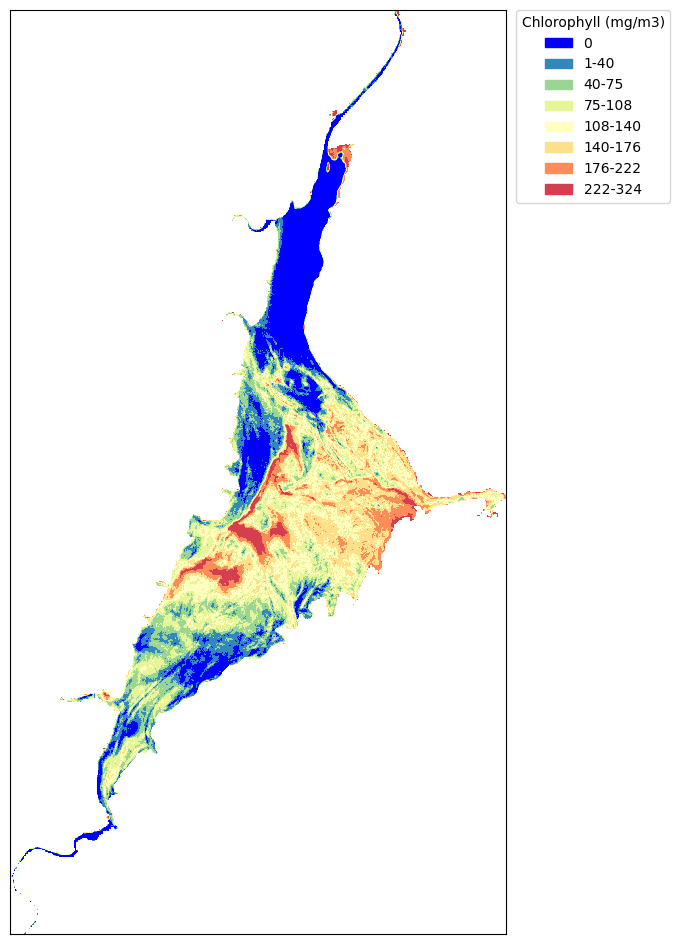

In [8]:
f, ax = plt.subplots(figsize = (12,12))

colors = ['blue', '#3288bd', '#99d594', '#e6f598', '#ffffbf', '#fee08b', '#fc8d59', '#d53e4f']
chl_conc = ['0', '1-40', "40-75", "75-108", "108-140", "140-176", "176-222", "222-324"]

# Custom colorbar
bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

# Mask out water in image - raster still contains water as nodata (255)
ep.plot_bands(classified_chloro.where(classified_chloro < 100), cmap = cmap, norm = norm, ax = ax, cbar = False) #

patches = [mpatches.Patch(color=colors[i], label = chl_conc[i]) for i in range(8)]
plt.legend(handles=patches , bbox_to_anchor=(1.02, 1), loc = 2, borderaxespad=0. , title = "Chlorophyll (mg/m3)");

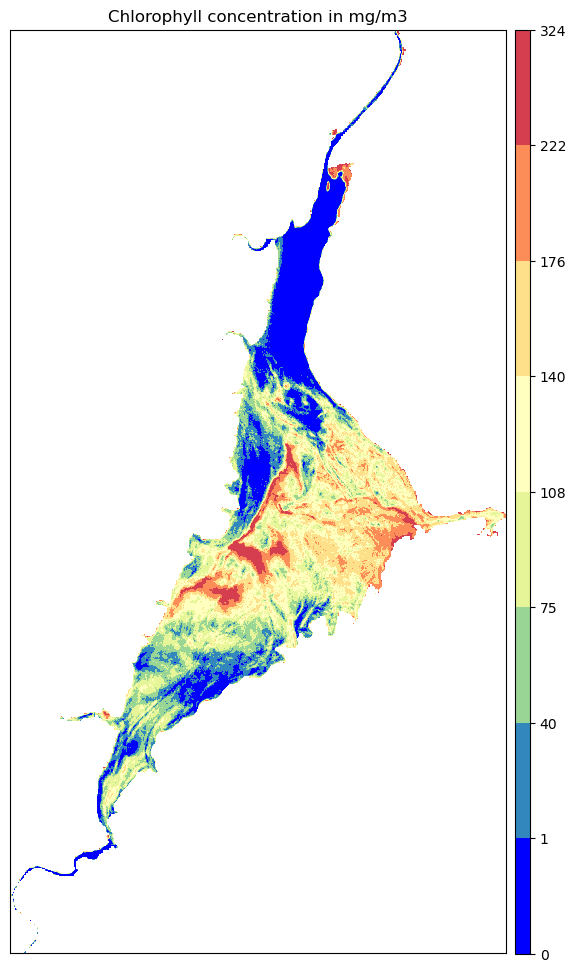

In [9]:
f, ax = plt.subplots(figsize = (12,12))

colors = ['blue', '#3288bd', '#99d594', '#e6f598', '#ffffbf', '#fee08b', '#fc8d59', '#d53e4f']
chl_conc = ['0', '1', '40', "75", "108", "140", "176", "222", "324"]

# Custom colorbar
# bins = [0, 1, 2, 3, 4, 5, 6, 7]
bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, 
                    len(colors))

ax.set_title("Chlorophyll concentration in mg/m3")

# Mask out water in image - raster still contains water as nodata (255)
ep.plot_bands(classified_chloro.where(classified_chloro < 100), cmap = cmap, norm = norm, ax = ax, cbar = False) #

cbar = ep.colorbar(ax.get_images()[0])

# cbar.set_ticks(np.unique(xr.apply_ufunc(np.digitize, ds, bins)).squeeze()[:-1])
cbar.set_ticklabels(chl_conc)

<Axes: >

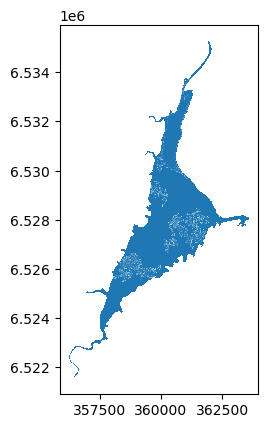

In [87]:
# Create a polygon of the fire affected area
# Speed of this process can be significantly increased if it is classified first.
import rasterio as rio

chloro = rio.features.shapes(
    classified_chloro, 
    mask = classified_chloro != 255, # burn areas only, remember to exclude nodata (255)
    transform = classified_chloro.rio.transform()
)

polygons = list(chloro)
        
geom = [shape(x[0]) for x in polygons]
values = [x[1] for x in polygons]
chloro_df = gpd.GeoDataFrame({"chloro_bin": values, "geometry": geom}, crs = classified_chloro.rio.crs)

chloro_df.plot()

In [88]:
# Area of each polygon
chloro_df["area"] = chloro_df.area / 1000000

# The geodataframe can also be used to calculate summary statistics, e.g. total severely burned area = 30km2
chloro_df[["chloro_bin", "area"]].groupby("chloro_bin").agg("sum")

,area
chloro_bin,
0.0,2.9781
1.0,1.8180
2.0,2.1126
3.0,2.2842
4.0,2.3517
5.0,2.1653
6.0,1.1974
7.0,0.5860


In [89]:
chloro_df.to_file("chl_conc_ndvi_algo.geojson", driver = "GeoJSON")